# Event-Driven Data Engineering: Analyzing Geopolitical/Social Sentiment for FMCG Market Impact

The primary goal is to demonstrate the process of extracting unstructured news data via an external API, performing data transformation (including Sentiment Analysis) using Python, and loading the results into a relational database (DWH) via SQL.

This project emphasizes production-readiness by utilizing Docker for containerization and outlining the architecture for Airflow DAGs to ensure scheduled and scalable execution.

**Key Concepts Demonstrated:**

- Python-based ETL logic and modularity.

- Advanced SQL for aggregation and analysis.

- Basic concepts of containerization (Docker) and orchestration (Airflow).

- Data preparation for business-relevant analysis (e.g., market risk assessment).

### 🛠️ Execution Flow

The entire process is broken down into modular steps, with core logic housed in separate `.py` scripts (e.g., `src/extract.py`) to maintain modularity.

#### Step 1: Initialization & Extraction (E)

1.  **Setup:** Install all necessary dependencies (`pandas`, `requests`, `sqlalchemy`, `nltk`, etc.).
2.  **API Call:** Use a Python function (`fetch_news_data`) to connect to an external News API and pull raw, event-driven data based on defined query terms.
3.  **Data Ingestion:** Convert the raw JSON response into a preliminary DataFrame.

#### Step 2: Transformation (T)

1.  **Cleaning & Structuring:** Handle missing values, convert data types, and prepare the DataFrame.
2.  **Sentiment Analysis:** Apply NLTK's VADER analyzer to article headlines/summaries to generate a **compound sentiment score**.
3.  **Feature Creation:** Add the resulting `sentiment_score` column to the clean DataFrame.

#### Step 3: Loading (L) and DWH Basics

1.  **Schema Definition:** Connect to the local SQL database (`news_dwh.db`).
2.  **Data Load:** Use the loading function to insert the clean, transformed data into the target table (`sentiment_articles`), demonstrating DWH insertion logic.

#### Step 4: Advanced SQL and Production Concept

1.  **Analytical SQL:** Execute a complex SQL query utilizing **CTE** and **Window Functions** to calculate the **7-day rolling average sentiment score**, showcasing strong analytical skills.
2.  **Production Concept:** Document the architecture: the use of a **`Dockerfile`** for

In [4]:
!pip install -q nltk

In [3]:
import pandas as pd 
import requests 
import sqlite3
import nltk
import seaborn as sns
import plotly as plt
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from src.extract import fetch_news_data
from src.transform_load import clean_and_analyze_data, load_to_database

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


**We chose VADER (Valence Aware Dictionary and sEntiment Reasoner) for its efficiency and accuracy in analyzing short-form online text (like news headlines).**

In [4]:
# downloading dictionary for further sentiment analysis
# VADER lexicon was specifically constructed for analysing text for social media
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except nltk.downloader.DownloadError:
    nltk.download('vader_lexicon')

### Starting data extraction from NewsAPI

In [5]:
API_KEY = "7dc45bf9d5164348a8456170f293aef2" 
NEWS_API_URL = "https://newsapi.org/v2/everything"

In [6]:
QUERY_TERM = "consumer spending OR supply chain OR FMCG market"
LIMIT_DAYS = 30
PAGE_SIZE = 100

**Due to the constratints of NewsAPI we can load not more than 100 articles**

In [7]:
raw_articles_list = fetch_news_data(
    api_key=API_KEY, 
    query=QUERY_TERM, 
    days_limit=LIMIT_DAYS, 
    page_size=PAGE_SIZE
)

-> Starting extraction for query: 'consumer spending OR supply chain OR FMCG market'...
-> Successfully extracted 98 articles.


In [8]:
data = pd.DataFrame(raw_articles_list)

In [9]:
data.head()

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': 'fortune', 'name': 'Fortune'}","Nick Lichtenberg, Eva Roytburg",‘The tariffs are a big tax increase’: Top bank...,"""A decent chunk of the economy is in recession...",https://fortune.com/2025/11/12/tariffs-big-tax...,https://fortune.com/img-assets/wp-content/uplo...,2025-11-12T22:39:30Z,Bust or boom? Thats the big question at the he...
1,"{'id': None, 'name': 'The Indian Express'}",Sohini Ghosh,Delhi HC refuses J&J arm relief to clear stock...,"The Centre, through the regulatory body Food S...",https://indianexpress.com/article/legal-news/d...,https://images.indianexpress.com/2025/11/Delhi...,2025-11-12T22:26:46Z,The Delhi High Court Wednesday refused Johnson...
2,"{'id': None, 'name': 'WWD'}",Evanclarkwwd,What Saks Global Has Riding on the Holiday Sea...,Saks Global's holiday season is pivotal as the...,http://wwd.com/business-news/financial/saks-gl...,https://wwd.com/wp-content/uploads/2025/11/Get...,2025-11-12T22:26:40Z,The holiday season is always make or break in ...
3,"{'id': None, 'name': 'Forbes'}","Brin Snelling, Contributor, \n Brin Snelling, ...",Malbon Expands Its Retail Footprint With New L...,"With eight stores open across the U.S., one in...",https://www.forbes.com/sites/brinsnelling/2025...,https://imageio.forbes.com/specials-images/ima...,2025-11-12T22:21:46Z,Malbon's Melrose Place store is located at 847...
4,"{'id': None, 'name': 'Notebookcheck.net'}",Jean Leon,POCO F8 Ultra hits Geekbench with 16GB RAM & S...,"Xiaomi is gearing up to launch a new ""affordab...",https://www.notebookcheck.net/POCO-F8-Ultra-hi...,https://www.notebookcheck.net/fileadmin/Notebo...,2025-11-12T22:12:00Z,Xiaomi is preparing to unleash new high-perfor...


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   source       98 non-null     object
 1   author       93 non-null     object
 2   title        98 non-null     object
 3   description  98 non-null     object
 4   url          98 non-null     object
 5   urlToImage   95 non-null     object
 6   publishedAt  98 non-null     object
 7   content      98 non-null     object
dtypes: object(8)
memory usage: 6.3+ KB


In [11]:
print(f'Date and time of the earliest article parced: {data['publishedAt'].min()}')
print(f'Date and time of the latest article parced {data['publishedAt'].max()}')

Date and time of the earliest article parced: 2025-11-12T15:31:00Z
Date and time of the latest article parced 2025-11-12T22:39:30Z


**The Articles parced from the News API encompass only news published within one day**

### Transformation (T): Data Cleaning and Sentiment Analysis 

In [16]:
if not data.empty:
    transformed_df = clean_and_analyze_data(data)

    if not transformed_df.empty:
        print("\n--- Transformed Data Preview (First 5 records with Sentiment Score) ---")
        print(transformed_df.head())
        print(f"\nFinal Transformed Data Shape: {transformed_df.shape}")
else:
    print("\n[!] Cannot run Transformation: Raw data is empty.")


--- Transformed Data Preview (First 5 records with Sentiment Score) ---
                publishedAt  \
0 2025-11-12 22:39:30+00:00   
1 2025-11-12 22:26:46+00:00   
2 2025-11-12 22:26:40+00:00   
3 2025-11-12 22:21:46+00:00   
4 2025-11-12 22:12:00+00:00   

                                               title         source_name  \
0  ‘The tariffs are a big tax increase’: Top bank...             Fortune   
1  Delhi HC refuses J&J arm relief to clear stock...  The Indian Express   
2  What Saks Global Has Riding on the Holiday Sea...                 WWD   
3  Malbon Expands Its Retail Footprint With New L...              Forbes   
4  POCO F8 Ultra hits Geekbench with 16GB RAM & S...   Notebookcheck.net   

                                                 url  sentiment_score  
0  https://fortune.com/2025/11/12/tariffs-big-tax...           0.2023  
1  https://indianexpress.com/article/legal-news/d...           0.6908  
2  http://wwd.com/business-news/financial/saks-gl...           0.40

In [17]:
transformed_df.head()

,publishedAt,title,source_name,url,sentiment_score
0,2025-11-12 22:39:30+00:00,‘The tariffs are a big tax increase’: Top bank...,Fortune,https://fortune.com/2025/11/12/tariffs-big-tax...,0.2023
1,2025-11-12 22:26:46+00:00,Delhi HC refuses J&J arm relief to clear stock...,The Indian Express,https://indianexpress.com/article/legal-news/d...,0.6908
2,2025-11-12 22:26:40+00:00,What Saks Global Has Riding on the Holiday Sea...,WWD,http://wwd.com/business-news/financial/saks-gl...,0.4019
3,2025-11-12 22:21:46+00:00,Malbon Expands Its Retail Footprint With New L...,Forbes,https://www.forbes.com/sites/brinsnelling/2025...,0.1027
4,2025-11-12 22:12:00+00:00,POCO F8 Ultra hits Geekbench with 16GB RAM & S...,Notebookcheck.net,https://www.notebookcheck.net/POCO-F8-Ultra-hi...,0.1027


We chose **VADER (Valence Aware Dictionary and sEntiment Reasoner)** for its **efficiency** and **accuracy** in analyzing short-form online text (like news headlines).

VADER is a lexicon- and rule-based tool, making it **computationally light**—perfect for a fast ETL pipeline. It provides a robust, normalized **Compound Score** (between -1.0 and +1.0) which is directly added as the structured **`sentiment_score`** feature.

| `sentiment_score` Range | Interpretation | DWH Impact |
| :--- | :--- | :--- |
| **+0.05 to +1.0** | **Positive Sentiment.** | Score increases the average **rolling sentiment** for the period. |
| **-0.05 to +0.05** | **Neutral Sentiment.** | Score is close to zero; neutral influence. |
| **-1.0 to -0.05** | **Negative Sentiment.** | Score decreases the average **rolling sentiment** for the period. |

''

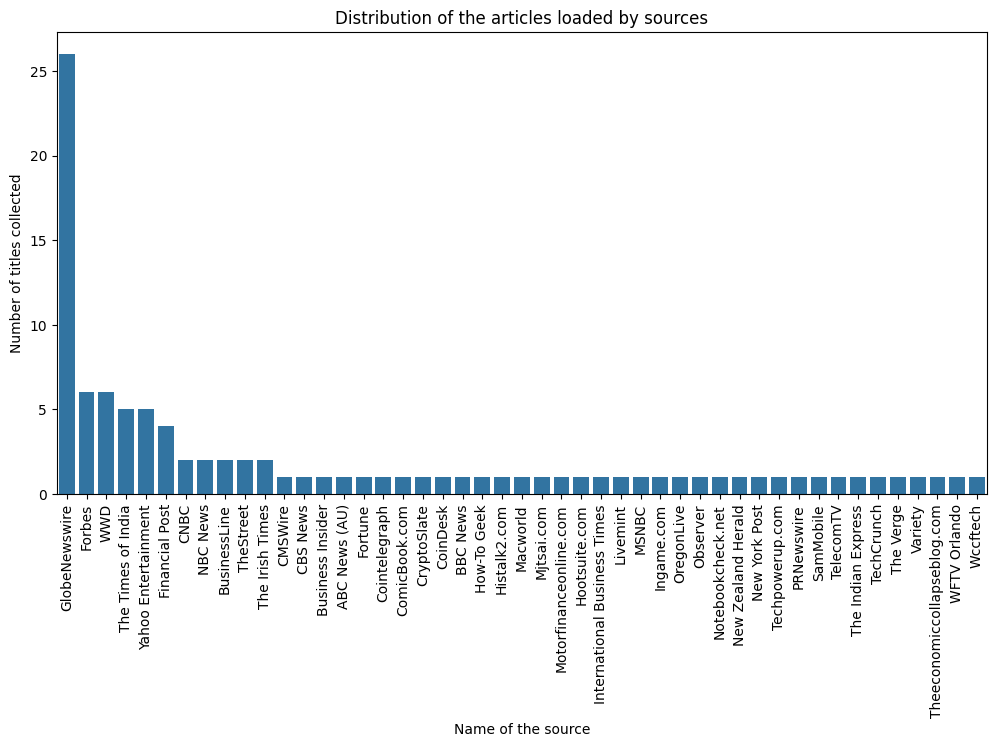

In [18]:
df0 = pd.DataFrame(transformed_df.groupby('source_name')['title'].count().reset_index().sort_values(by='title', ascending=False))

plt.figure(figsize=(12, 6))
sns.barplot(data = df0, x='source_name', y='title')

plt.title('Distribution of the articles loaded by sources')
plt.xlabel('Name of the source')
plt.ylabel('Number of titles collected')
plt.xticks(rotation=90, ha='center')
;

''

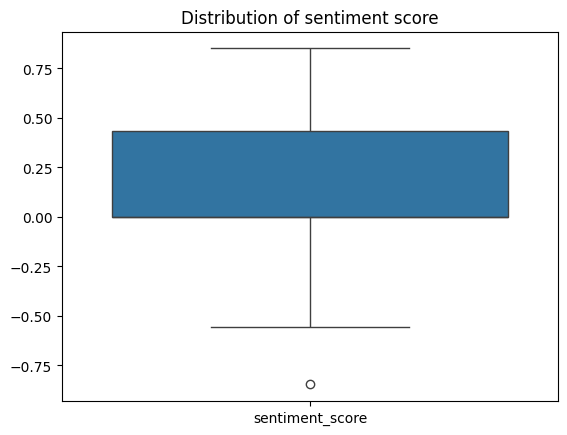

In [19]:
sns.boxplot(transformed_df)
plt.title('Distribution of sentiment score')
;

**Positive sentiments are prevailing in the articles collected based on the distribution of the sentiment score. However, still the value varies from -0.5 to about 0.75 (from negative to positive). There is also one outlier that represents highly negative sentiment of the title.**

### Loading(L): Loading data to SQL database

In [20]:
if 'transformed_df' in locals() and not transformed_df.empty:
    DB_NAME = 'news_dwh.db'
    TABLE_NAME = 'sentiment_articles'
    
    load_to_database(transformed_df, DB_NAME, TABLE_NAME)
else:
    print("\n[!] Cannot run Load step: 'transformed_df' is empty or not defined.")

-> Successfully loaded 98 records into table 'sentiment_articles'.


In [21]:
conn = sqlite3.connect(DB_NAME)

In [22]:

SIMPLE_QUERY = "SELECT title, " \
"sentiment_score " \
"FROM sentiment_articles " \
"WHERE sentiment_score > 0.5 " \
"ORDER BY sentiment_score DESC;" \


positive_articles_df = pd.read_sql_query(SIMPLE_QUERY, conn)
positive_articles_df.head()

,title,sentiment_score
0,From Profit to Purpose: The Next Generation’s ...,0.8519
1,Face wash to oral care: Mamaearth parent's new...,0.8271
2,Society Insider: Rich-list property developer ...,0.8225
3,SHAKLEE SPARKLING PROTEIN™ RETURNS AFTER SELLI...,0.8109
4,James Allen Just Released a Charm Collection f...,0.8016


In [23]:
SIMPLE_QUERY = "SELECT title, " \
"sentiment_score " \
"FROM sentiment_articles " \
"WHERE sentiment_score < 0.5 " \
"ORDER BY sentiment_score ASC;" \


negative_articles_df = pd.read_sql_query(SIMPLE_QUERY, conn)
negative_articles_df.head()

,title,sentiment_score
0,ECB to cut rates twice this year? Will the Eur...,-0.8463
1,Congress Moves To End Shutdown While Enacting ...,-0.5574
2,Disney Q4 revenue misses estimates amid linear...,-0.4939
3,AMD CEO Lisa Su Speaks Out Against Fears Surro...,-0.4215
4,Trump’s 50-year mortgages lose steam as indust...,-0.4019


In [24]:
SQL_ANALYSIS_QUERY = (
 "WITH Source_Tonnage AS ("
    "    SELECT"
    "        source_name,"
    "        COUNT(title) AS article_count,"
    "        ROUND(AVG(sentiment_score), 4) AS source_avg_sentiment,"
    "        ROUND(AVG(sentiment_score) OVER (), 4) AS overall_avg_sentiment"
    "    FROM sentiment_articles"
    "    GROUP BY 1"
    "    HAVING article_count > 3"  # <-- ИЗМЕНЕНО: Фильтр на более 3 статей
    "),"
    "Comparison AS ("
    "    SELECT"
    "        *,"
    "        ROUND(source_avg_sentiment - overall_avg_sentiment, 4) AS deviation_from_total"
    "    FROM Source_Tonnage"
    ")"
    "SELECT"
    "    source_name,"
    "    article_count,"
    "    source_avg_sentiment,"
    "    overall_avg_sentiment,"
    "    deviation_from_total,"
    "    CASE"
    "        WHEN deviation_from_total > 0.05 THEN 'More Positive'"
    "        WHEN deviation_from_total < -0.05 THEN 'More Negative'"
    "        ELSE 'Neutral'"
    "    END AS sentiment_bias"
    " FROM Comparison"
    " ORDER BY deviation_from_total DESC"
)

In [25]:
article_sources_class = pd.read_sql_query(SQL_ANALYSIS_QUERY, conn)
article_sources_class.head()

,source_name,article_count,source_avg_sentiment,overall_avg_sentiment,deviation_from_total,sentiment_bias
0,WWD,6,0.2676,0.0164,0.2512,More Positive
1,GlobeNewswire,26,0.2496,0.0164,0.2332,More Positive
2,Financial Post,4,0.1263,0.0164,0.1099,More Positive
3,The Times of India,5,0.0594,0.0164,0.0430,Neutral
4,Forbes,6,-0.0371,0.0164,-0.0535,More Negative
